In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

In [2]:
df_hospital = pd.read_csv('../data/hospital_visits.csv')
df_hospital['Week'] = df_hospital.Week.map(str) + "-" + df_hospital.Year.map(str)
df_hospital = df_hospital[['Total ILI']]
list_data = list(df_hospital['Total ILI'])

In [3]:
list_data = list(df_hospital['Total ILI'])

In [4]:
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
#     print(len(history))
#     print(len(train_features))
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# walk-forward validation for univariate data
def walk_forward_validation(data, cfg):
    
    predictions = list()
    # split dataset
    train, test = train_test_split(data, 52)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    
#     print((len(train_features), len(train_features[0])))
#     print(len(history))
    
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    # print(error)
    return error

# score a model, return None on failure
def score_model(data, cfg, debug=False):
    print(cfg)
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, cfg)
    else:
        # # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [5]:
def grid_search(data, cfg_list, parallel=True):    
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, cfg) for cfg in cfg_list]
    # remove empty results
    print(scores)
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [6]:
# create a set of sarima configs to try
def sarima_configs():
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
#     t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m = 52
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            cfg = [(p,d,q), (P,D,Q,m), "c"]
                            models.append(cfg)
    return models

In [7]:
# define dataset
data = list_data
# model configs
cfg_list = sarima_configs()
print("configs done")

configs done


In [ ]:
scores = grid_search(data, cfg_list)
print('done')
# list top 3 configs
for cfg, error in scores[:5]:
    print(cfg, error)

In [12]:
model = SARIMAX(list_data[:-52], order=(1, 1, 0), seasonal_order=(1, 1, 0, 52))
model_fit = model.fit(disp=False)

In [13]:
# make prediction
future = 52
# predictions = model_fit.predict(len(list_data), len(list_data) + future)
predictions = model_fit.forecast(future)
print(predictions)
# future_weeks = list(range(len(list_data) - 1, len(list_data) + future))
future_weeks = list(range(len(list_data) - 53, len(list_data) + future - 1))
# future_weeks

[25908.21457064 24062.99635026 27326.88688193 28173.7152793
 32849.3860609  41136.45077238 43909.80471958 44919.3737014
 51215.4055427  56600.58981251 66577.07685977 73999.58601421
 77491.81676897 69437.25157929 54325.11569591 39940.68800449
 34771.79128464 31813.22125477 31136.41679329 28070.2440747
 25335.16201543 22299.45751577 20236.713748   19648.33291172
 18413.16071199 17141.31831864 16652.70717702 15890.68784888
 14960.26109423 14309.45347813 13260.11968531 12993.18732202
 12482.33366863 11954.02832202 11972.66901311 11438.47238234
 11304.25679947 11376.60478507 11537.93539757 12080.33365916
 13066.34024141 13733.74640005 14593.53318241 15330.35234689
 15953.55502907 16045.0667421  22150.60451045 22737.02330427
 23944.2609978  25567.3270674  26993.92064393 28299.89274446]


In [14]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI: 2014 - 2019 + predictions')

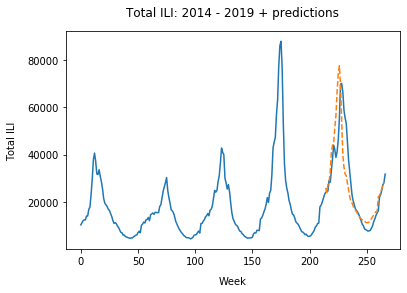

In [15]:
plt.plot(df_hospital['Total ILI'])
plt.plot(predictions_df, '--')
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014 - 2019 + predictions", pad=15)

In [8]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  215
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1510.943
Date:                            Mon, 09 Dec 2019   AIC                           3027.885
Time:                                    17:36:35   BIC                           3037.148
Sample:                                         0   HQIC                          3031.646
                                            - 215                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5771      0.050     11.445      0.000       0.478       0.676
ar.S.L52      -0.3638      0.074     -4.886      0.000      -0.510      -0.218
sigma2       7.75e+06   5.38e+05     14.397      0.000    6.69e+06     8.8e+06
===================================================================================
Ljung-Box (Q):                       29.72   Jarque-Bera (JB):               817.15
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                            -1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""